## Summary
This script performs Monte Carlo simulation for theoretical "rebalancing" strategies during the Great Financial Crisis (2007 to 2009), with the goal to test whether rebalancing help performance during a crisis.

In [126]:
# Import libraries and dependencies
from os import path
from datetime import datetime

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
fpath = r'D:\Git\rebal-sim'
retFile = 'SimData.txt'

### Load Pre-Calculated Return Data
Below table contains 3 months forward return for:
* "Reversion" rebalance (Ret_r, calculated as D1-D10); 
* "Momentum" rebalance (Ret_m, calculated as D10-D1); 
* Russell 3000 (Ret_i)

In [69]:
df_Ret = pd.read_csv(path.join(fpath, retFile), sep = '\t', parse_dates=["Date"])


In [70]:
# add Ret_n to represent "do nothing" for future iteration
df_Ret['Ret_n']=0.0
df_Ret

,Date,Ret_r,Ret_m,Ret_i,Ret_n
0,2007-03-01,-5.6560,5.6560,5.324168,0.0
1,2007-06-01,-9.6478,9.6478,1.099414,0.0
2,2007-09-01,-14.5031,14.5031,-3.802717,0.0
3,2007-12-01,0.7328,-0.7328,-9.960902,0.0
4,2008-03-01,-7.5280,7.5280,-2.161834,0.0
5,2008-06-01,37.8210,-37.8210,-9.303566,0.0
6,2008-09-01,-23.3657,23.3657,-23.271927,0.0
7,2008-12-01,7.3092,-7.3092,-11.421430,0.0
8,2009-03-01,27.7366,-27.7366,16.151272,0.0
9,2009-06-01,-15.2142,15.2142,15.729435,0.0


### Set simulation parameters


In [119]:
# choice of a) reversion balance, b) momentum balance, or c) do nothing
l_choice = ['Ret_r','Ret_m','Ret_n']

# probability of doing a) reversion balance, b) momentum balance, or c) do nothing
l_prob = [0.3,0.3,0.4]

# number of simulation to do
num_sim = 1000

### Simulation

Assuming we have a long only R3K index strategy, with 10% notional Long/Short overlay for opportunistic rebalancing (i.e. at each point, the PM can discretionarily choose among 1) reversion rebalancing (long 10% notional D1, short 10% notional D10), 2) momentum rebalancing (long 10% notional D10, short 10% notional D1), and 3) do nothing, with specified probability. For trial purpose, I use [0.2,0.2,0.6], but one change it to reflect their own inclination (either more "value", thus higher prob for "reversion", or vice versa).

In [120]:
# Set strategy parameters

# overlay notional
oln = 0.2

In [121]:
# Creat an empty DF to store simulation results
df_sim = pd.DataFrame()

df_sim['Date'] = df_Ret['Date']

# Run num_sim times simulation using for loop
for i in range(num_sim):
    # print(f'Running simulation for itration {i}...')
    
    # create an empty list to store sim'd ret series
    l_ret = []
    
    for j, d in enumerate(df_sim['Date']):
        # print(f'Simulating return for {j} {d}')
        
        # Random draw
        rd = np.random.choice(l_choice, p=l_prob)
        
        # get overlay part return
        ret = df_Ret[rd][j]
        
        # calculate full return (100% + index return + overlay return)
        ret_full = 1 + df_Ret['Ret_i'][j]/100 + ret*oln/100
        
        # print(f'randomly draw {rd}, return of {ret_full}')
        
        l_ret.append(ret_full)
    
    # append return stream to data frame
    df_sim[f'Sim_{i}'] = pd.Series(l_ret)

# df_sim
        
        
        



In [122]:
# Create cumulative return DF

df_CumRet = pd.DataFrame()

df_CumRet['Date'] = df_Ret['Date']

for i in range(num_sim):
    df_CumRet[f'CumRet_{i}'] = np.cumprod(df_sim[f'Sim_{i}'])

# df_CumRet

### Stats Summary & Visualization

A few options:
* Cumulative return path chart
* End value distribution chart

In [75]:
# set Date as index for ploting
# df_CRMelt = pd.melt(df_CumRet, id_vars=['Date'])
# df_CumRet.set_index('Date', inplace=True)


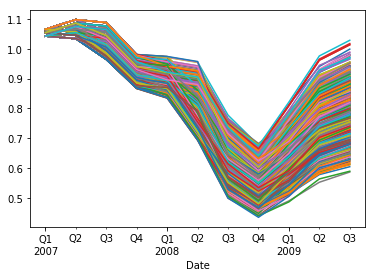

In [123]:
# plot cum return path chart
df_CumRet.plot(x='Date', legend=None)



In [124]:
l_EndV = df_CumRet.iloc[10,1:].tolist()
s_EndV = pd.Series(l_EndV)
s_EndV.describe()


count    1000.000000
mean        0.788646
std         0.079328
min         0.587666
25%         0.733055
50%         0.782056
75%         0.841702
max         1.027896
dtype: float64

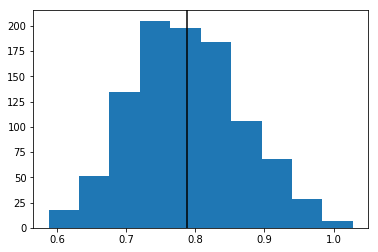

In [125]:
# histogram of end value distribution
plt.hist(s_EndV)

# draw a vertical line of "do nothing"
r3k_EndV = 0.787805

plt.axvline(x=r3k_EndV, color='black')


In [131]:
# statistical test
sp.stats.ttest_1samp(s_EndV,r3k_EndV)

Ttest_1sampResult(statistic=0.33520219918656974, pvalue=0.7375429366364625)